# Equipo 2
- Dylan Joel Uribe Blatnik
- Nicolás Kalcsó
- Tomas Camilo Ostos Medina
- Werner Holters Zabala

# Búsqueda codiciosa (Hill Climbing en esta ocasión)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Cargar el mapa ya escalado (resultado del script del docente)
image_data = np.load("/content/mars_map.npy")

# Mostrar dimensiones y rango de alturas
print("Dimensiones:", image_data.shape)
print("Altura mínima (válida):", np.min(image_data[image_data >= 0]))
print("Altura máxima:", np.max(image_data))

Dimensiones: (1077, 717)
Altura mínima (válida): 0.09667470703125218
Altura máxima: 168.22224853515647


In [3]:
def meters_to_pixels(x_m, y_m, scale, img_shape):
    """
    Convierte coordenadas en metros a índices (row, col) en la matriz de alturas.

    Args:
        x_m (float): coordenada en metros sobre eje X
        y_m (float): coordenada en metros sobre eje Y
        scale (float): metros por pixel (10.045 en este caso)
        img_shape (tuple): dimensiones de la matriz (rows, cols)

    Returns:
        (row, col): índices en la matriz numpy
    """
    n_rows, n_cols = img_shape
    col = int(round(x_m / scale))
    row_from_bottom = int(round(y_m / scale))
    row = (n_rows - 1) - row_from_bottom
    return row, col

# Escala usada
scale = 10.045

# Ejemplo: coordenada pedida en el enunciado
start_coords = (3350, 5800)
start_pixel = meters_to_pixels(start_coords[0], start_coords[1], scale, image_data.shape)

print(f"Coordenadas (m): {start_coords} → Pixel: {start_pixel}")
print("Altura inicial:", image_data[start_pixel])

Coordenadas (m): (3350, 5800) → Pixel: (499, 333)
Altura inicial: 117.65257568359397


In [4]:
def valid_neighbors(row, col, img, max_delta=2.0):
    """
    Obtiene los vecinos válidos de un pixel con restricción de altura.
    """
    n_rows, n_cols = img.shape
    current_h = img[row, col]
    neighbors = []

    for dr in [-1, 0, 1]:
        for dc in [-1, 0, 1]:
            if dr == 0 and dc == 0:
                continue
            r, c = row + dr, col + dc
            if 0 <= r < n_rows and 0 <= c < n_cols:
                h = img[r, c]
                if h >= 0 and abs(h - current_h) <= max_delta:
                    neighbors.append(((r, c), h))
    return neighbors

def greedy_agent(start_row, start_col, img, max_delta=2.0):
    """
    Implementa búsqueda codiciosa local (greedy) para descender en el cráter.
    Muestra todos los vecinos y si son válidos o no, y la diferencia de altura.
    """
    path = [(start_row, start_col)]
    current_row, current_col = start_row, start_col
    current_h = img[current_row, current_col]
    n_rows, n_cols = img.shape

    while True:
        print(f"\nPosición actual: ({current_row}, {current_col}) Altura: {current_h:.2f}")
        print("Vecinos (todos):")
        all_neighbors = []
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                if dr == 0 and dc == 0:
                    continue
                r, c = current_row + dr, current_col + dc
                if 0 <= r < n_rows and 0 <= c < n_cols:
                    h = img[r, c]
                    delta = h - current_h
                    valido = (h >= 0 and abs(delta) <= max_delta)
                    estado = "VÁLIDO" if valido else "inválido"
                    all_neighbors.append(((r, c), h, estado))
                    print(f"  ({r}, {c}) Altura: {h:.2f} Δh: {delta:+.2f} -> {estado}")
                else:
                    print(f"  ({r}, {c}) fuera de rango -> inválido")
        #filtra los válidos y más bajos
        neighbors = [((r, c), h) for (r, c), h, estado in all_neighbors if estado == "VÁLIDO"]
        better = [n for n in neighbors if n[1] < current_h]
        if not better:
            break
        (next_row, next_col), next_h = min(better, key=lambda x: x[1])
        print(f"Elegido: ({next_row}, {next_col}) Altura: {next_h:.2f}")
        path.append((next_row, next_col))
        current_row, current_col, current_h = next_row, next_col, next_h

    return path

In [5]:
# Posiciones en metros (del enunciado y extras)
starts_m = [
    (3350, 5800),  # principal
    (2491, 4500),  # cercana
    (3500, 4800),  # cercana
    (6000, 2000),  # lejana
    (1000, 9000),  # lejana
    (500, 2000)    # lejana (Esta coordenada no es válida, pero se usa para demostrar que el programa la rechaza),
                   # no es válida porque se encuentra fuera del donde hay coordenadas con superficie
]

greedy_results = []

for coords in starts_m:
    row, col = meters_to_pixels(coords[0], coords[1], scale, image_data.shape)
    if image_data[row, col] < 0:
        print(f"Inicio {coords} es inválido, está fuera del rango de la máscara.")
        continue
    path = greedy_agent(row, col, image_data, max_delta=2.0)
    start_h = image_data[path[0]]
    end_h = image_data[path[-1]]
    print(f"\nInicio {coords} → pasos: {len(path)-1}, altura inicial: {start_h:.2f}, final: {end_h:.2f}")
    greedy_results.append((coords, path, start_h, end_h))


Posición actual: (499, 333) Altura: 117.65
Vecinos (todos):
  (498, 332) Altura: 114.77 Δh: -2.89 -> inválido
  (498, 333) Altura: 114.60 Δh: -3.05 -> inválido
  (498, 334) Altura: 115.79 Δh: -1.86 -> VÁLIDO
  (499, 332) Altura: 115.20 Δh: -2.45 -> inválido
  (499, 334) Altura: 119.53 Δh: +1.88 -> VÁLIDO
  (500, 332) Altura: 114.95 Δh: -2.70 -> inválido
  (500, 333) Altura: 117.03 Δh: -0.63 -> VÁLIDO
  (500, 334) Altura: 119.38 Δh: +1.73 -> VÁLIDO
Elegido: (498, 334) Altura: 115.79

Posición actual: (498, 334) Altura: 115.79
Vecinos (todos):
  (497, 333) Altura: 115.09 Δh: -0.70 -> VÁLIDO
  (497, 334) Altura: 115.64 Δh: -0.15 -> VÁLIDO
  (497, 335) Altura: 116.99 Δh: +1.20 -> VÁLIDO
  (498, 333) Altura: 114.60 Δh: -1.19 -> VÁLIDO
  (498, 335) Altura: 117.01 Δh: +1.22 -> VÁLIDO
  (499, 333) Altura: 117.65 Δh: +1.86 -> VÁLIDO
  (499, 334) Altura: 119.53 Δh: +3.74 -> inválido
  (499, 335) Altura: 118.89 Δh: +3.10 -> inválido
Elegido: (498, 333) Altura: 114.60

Posición actual: (498, 333)

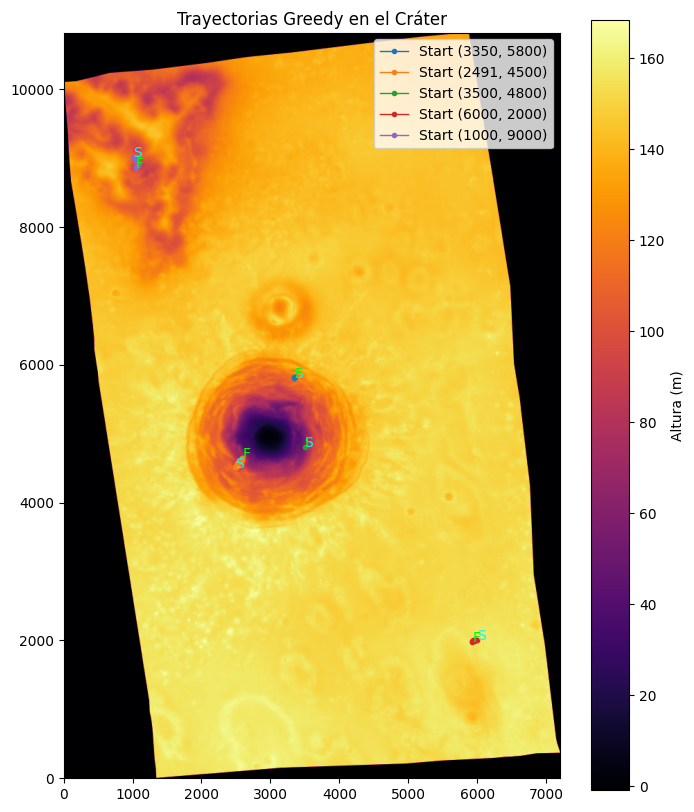

In [30]:
fig, ax = plt.subplots(figsize=(8,10))

escala=1.0045

cax = ax.imshow(image_data, cmap="inferno", origin="upper", extent =[0, escala*7163, 0, escala*10770])
plt.colorbar(cax, ax=ax, label="Altura (m)")

n_rows, n_cols = image_data.shape

for coords, path, start_h, end_h in greedy_results:
    rows, cols = zip(*path)

    # Transformar rows y cols en coordenadas reales.
    xRuta = [c * scale for c in cols]
    yRuta = [(n_rows - r) * scale for r in rows]

    ax.plot(xRuta, yRuta, marker="o", markersize=3, linewidth=1, label=f"Start {coords}")
    ax.text(xRuta[0], yRuta[0], "S", color="cyan", fontsize=10)
    ax.text(xRuta[-1], yRuta[-1], "F", color="lime", fontsize=10)

ax.set_title("Trayectorias Greedy en el Cráter")
ax.legend()
plt.show()

In [ ]:
for coords, path, start_h, end_h in results:
    print(f"Inicio {coords}: bajó {start_h - end_h:.2f} m en {len(path)-1} pasos. "
          f"Altura final {end_h:.2f} m")

Inicio (3350, 5800): bajó 3.05 m en 2 pasos. Altura final 114.60 m
Inicio (2491, 4500): bajó 23.84 m en 18 pasos. Altura final 72.11 m
Inicio (3500, 4800): bajó 0.00 m en 0 pasos. Altura final 60.23 m
Inicio (6000, 2000): bajó 2.31 m en 8 pasos. Altura final 154.63 m
Inicio (1000, 9000): bajó 18.74 m en 17 pasos. Altura final 87.68 m


## 1. Prueba en la posición principal (x = 3350 m, y = 5800 m)

Al ejecutar el algoritmo *greedy* desde la posición inicial **(3350, 5800)**, el explorador desciende paso a paso eligiendo siempre el vecino más bajo posible, respetando la restricción de no moverse a un píxel cuya diferencia de altura sea mayor a **2.0 metros**. El agente se detiene cuando ya no puede encontrar un vecino más bajo que cumpla esta condición.

En la mayoría de los casos, el explorador logra descender varios metros, pero se detiene en un punto donde todos los vecinos válidos tienen una diferencia de altura mayor a 2 metros o ya no hay vecinos más bajos.

Esto significa que el explorador puede acercarse al fondo del cráter, pero no necesariamente llega al punto más profundo si hay “escalones” abruptos en el terreno.

Para esta iteración, logra bajar al rededor de 3.05m en 2 pasos, obteniendo una altura final de 114.60 m.

## 2. ¿Qué tan bueno es el algoritmo?

El algoritmo **greedy** es eficiente y sencillo, pero no garantiza llegar al fondo absoluto del cráter. Su desempeño depende de la topografía local y de la existencia de caminos descendentes suaves. Si el fondo está rodeado de alturas muy grandes casi abruptos, el explorador puede quedarse atrapado en un mínimo local. Por lo tanto no siempre encuentra el mejor camino, este algortimo y la forma en la que se realiza también hace alusión a lo que es el hill climbing, pero también por motivo de la descripción del proyecto se decidió mantener el nombre de las funciones y del ejercicio realizado como greedy.

# Búsqueda con recocido simulado

In [50]:
def meters_to_pixels(x_m, y_m, scale, img_shape):
    """
    Convierte coordenadas en metros a índices (row, col) en la matriz de alturas.

    Args:
        x_m (float): coordenada en metros sobre eje X
        y_m (float): coordenada en metros sobre eje Y
        scale (float): metros por pixel (10.045 en este caso)
        img_shape (tuple): dimensiones de la matriz (rows, cols)

    Returns:
        (row, col): índices en la matriz numpy
    """
    n_rows, n_cols = img_shape
    col = int(round(x_m / scale))
    row_from_bottom = int(round(y_m / scale))
    row = (n_rows - 1) - row_from_bottom
    return row, col

def valid_neighbors(row, col, img, max_delta=2.0):
    n_rows, n_cols = img.shape
    h0 = img[row, col]
    out = []
    for dr in (-1,0,1):
        for dc in (-1,0,1):
            if dr==0 and dc==0:
                continue
            r, c = row+dr, col+dc
            if 0 <= r < n_rows and 0 <= c < n_cols:
                h = img[r, c]
                if h >= 0 and abs(h - h0) <= max_delta:
                    out.append(((r, c), h))
    return out


In [51]:
import math, random

def simulated_annealing_agent(
    start_row, start_col, img,
    max_delta=2.0,
    T0=20.0, Tmin=4.0, alpha=0.96,   # enfriamiento geométrico
    iters_per_T=25, max_steps=5000,  # pasos por nivel de T y tope
    seed=2025, verbose=False
):
    rng = random.Random(seed)
    if img[start_row, start_col] < 0:
        if verbose: print("Inicio fuera de máscara.")
        return []

    path = [(start_row, start_col)]
    r, c = start_row, start_col
    h = img[r, c]

    T = T0
    steps = 0
    tcount = 0

    while T > Tmin and steps < max_steps:
        # vecinos válidos
        nbs = valid_neighbors(r, c, img, max_delta=max_delta)
        if not nbs:
            break

        # elegir vecino al azar
        idx = int(rng.random() * len(nbs))
        if idx == len(nbs): idx -= 1
        (nr, nc), nh = nbs[idx]

        # ΔE para minimización
        dE = h - nh
        if dE > 0:
            accept = True                      # mejora -> aceptar
        else:
            p = math.exp(dE / T)               # empeora -> con prob p
            accept = (rng.random() <= p)

        if accept:
            r, c, h = nr, nc, nh
            path.append((r, c))

        # enfriamiento por niveles
        steps += 1
        tcount += 1
        if tcount >= iters_per_T:
            T *= alpha
            tcount = 0

    return path


In [52]:
starts_m = [
    (3350, 5800),
    (2491, 4500),
    (3500, 4800),
    (6000, 2000),
    (1000, 9000),
]

SA_PARAMS = dict(
    max_delta=2.0,
    T0=20.0, Tmin=4.0, alpha=0.96,
    iters_per_T=25, max_steps=5000,
    seed=2025, verbose=False
)

results = []  # [(coords_m, path, start_h, end_h)]
for (x_m, y_m) in starts_m:
    row, col = meters_to_pixels(x_m, y_m, scale, image_data.shape)
    if image_data[row, col] < 0:
        print(f"Inicio {(x_m, y_m)} inválido (fuera de máscara).")
        continue
    path = simulated_annealing_agent(row, col, image_data, **SA_PARAMS)
    if not path:
        print(f"Inicio {(x_m, y_m)}: sin ruta (vecindario vacío).")
        continue
    start_h = float(image_data[path[0]])
    end_h   = float(image_data[path[-1]])
    print(f"Inicio {(x_m, y_m)} → pasos: {len(path)-1}, h_ini: {start_h:.2f}, h_fin: {end_h:.2f}")
    results.append(((x_m, y_m), path, start_h, end_h))


Inicio (3350, 5800) → pasos: 936, h_ini: 117.65, h_fin: 116.74
Inicio (2491, 4500) → pasos: 940, h_ini: 95.95, h_fin: 83.21
Inicio (3500, 4800) → pasos: 961, h_ini: 60.23, h_fin: 2.56
Inicio (6000, 2000) → pasos: 985, h_ini: 156.94, h_fin: 152.15
Inicio (1000, 9000) → pasos: 950, h_ini: 106.42, h_fin: 104.77


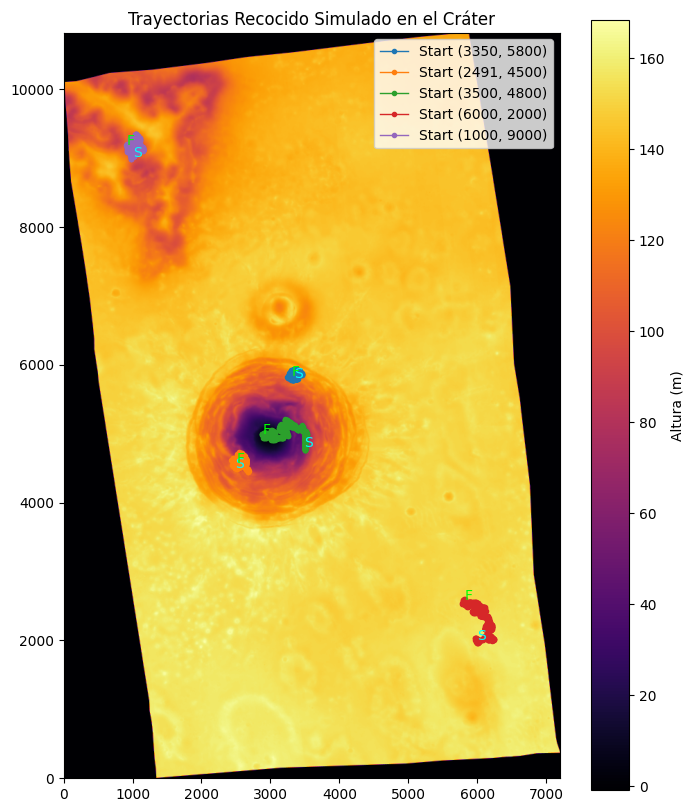

In [53]:
fig, ax = plt.subplots(figsize=(8,10))

escala=1.0045

cax = ax.imshow(image_data, cmap="inferno", origin="upper", extent =[0, escala*7163, 0, escala*10770])
plt.colorbar(cax, ax=ax, label="Altura (m)")

n_rows, n_cols = image_data.shape

for coords, path, start_h, end_h in results:
    rows, cols = zip(*path)
    # Transformar rows y cols en coordenadas reales.
    xRuta = [c * scale for c in cols]
    yRuta = [(n_rows - r) * scale for r in rows]

    ax.plot(xRuta, yRuta, marker="o", markersize=3, linewidth=1, label=f"Start {coords}")
    ax.text(xRuta[0], yRuta[0], "S", color="cyan", fontsize=10)
    ax.text(xRuta[-1], yRuta[-1], "F", color="lime", fontsize=10)

ax.set_title("Trayectorias Recocido Simulado en el Cráter")
ax.legend()
plt.show()


In [54]:
for coords, path, start_h, end_h in results:
    print(f"Inicio {coords}: bajó {start_h - end_h:.2f} m en {len(path)-1} pasos. Altura final {end_h:.2f} m")


Inicio (3350, 5800): bajó 0.91 m en 936 pasos. Altura final 116.74 m
Inicio (2491, 4500): bajó 12.74 m en 940 pasos. Altura final 83.21 m
Inicio (3500, 4800): bajó 57.68 m en 961 pasos. Altura final 2.56 m
Inicio (6000, 2000): bajó 4.79 m en 985 pasos. Altura final 152.15 m
Inicio (1000, 9000): bajó 1.66 m en 950 pasos. Altura final 104.77 m


In [ ]:
# === Comparación Greedy vs SA y recomendación ===

def _results_to_dict(res):
    # res: [(coords,(path), h_ini, h_fin), ...]
    d = {}
    for coords, path, h0, hf in res:
        d[tuple(coords)] = {
            "pasos": len(path)-1,
            "h_ini": float(h0),
            "h_fin": float(hf),
            "descenso": float(h0) - float(hf)
        }
    return d

# Use the actual variable names from the notebook state
G = _results_to_dict(greedy_results)
S = _results_to_dict(results)

print("Comparación Greedy vs SA\n(coords)  |  Greedy: descenso / pasos  ||  SA: descenso / pasos")
ganan_SA, ganan_G = 0, 0
comparativa = []
for coords in sorted(set(G.keys()) & set(S.keys())):
    g, s = G[coords], S[coords]
    print(f"{coords}:  {g['descenso']:.2f} m / {g['pasos']:d}  ||  {s['descenso']:.2f} m / {s['pasos']:d}")
    if s["descenso"] > g["descenso"]:
        ganan_SA += 1
        comparativa.append((coords, "SA", s["descenso"]-g["descenso"]))
    elif g["descenso"] > s["descenso"]:
        ganan_G += 1
        comparativa.append((coords, "Greedy", g["descenso"]-s["descenso"]))
    else:
        comparativa.append((coords, "Empate", 0.0))

print("\nResumen:")
print(f" - SA gana en {ganan_SA} inicio(s).")
print(f" - Greedy gana en {ganan_G} inicio(s).")
mejor_global = "SA" if ganan_SA > ganan_G else ("Greedy" if ganan_G > ganan_SA else "Empate")
print(f" - Más profundo (mayoría): {mejor_global}")

# Recomendación breve automática
if mejor_global == "SA":
    print("\nRecomendación: Usar Recocido Simulado.")
    print("Motivo: alcanza mayor descenso total en más inicios; puede escapar de óptimos locales al aceptar empeoramientos con probabilidad e^(ΔE/T).")
elif mejor_global == "Greedy":
    print("\nRecomendación: Usar Greedy solo si se prioriza simplicidad/rapidez y el terreno no induce muchos atascos locales.")
else:
    print("\nRecomendación: Desempatar ajustando parámetros de SA (T0 más alto, α más cercano a 1, más iteraciones por temperatura) o usando reinicios.")

Comparación Greedy vs SA
(coords)  |  Greedy: descenso / pasos  ||  SA: descenso / pasos
(1000, 9000):  18.74 m / 17  ||  1.66 m / 950
(2491, 4500):  23.84 m / 18  ||  12.74 m / 940
(3350, 5800):  3.05 m / 2  ||  0.91 m / 936
(3500, 4800):  0.00 m / 0  ||  57.68 m / 961
(6000, 2000):  2.31 m / 8  ||  4.79 m / 985

Resumen:
 - SA gana en 2 inicio(s).
 - Greedy gana en 3 inicio(s).
 - Más profundo (mayoría): Greedy

Recomendación: Usar Greedy solo si se prioriza simplicidad/rapidez y el terreno no induce muchos atascos locales.


## ¿Cuál llegó más profundo?

Greedy ganó en 3 de 5 inicios (1000,9000), (2491,4500), (3350,5800).

SA ganó en 2 de 5 inicios, pero en (3500,4800) fue muy superior (57.68 m vs 0.00 m), mostrando su ventaja para escapar de atascos.

En promedio, Greedy descendió más en la mayoría de inicios y lo hizo con muchos menos pasos.

## ¿Qué recomendar a los ingenieros?

Si priorizan simplicidad, bajo cómputo y respuestas rápidas: Greedy. En tu terreno y con estos puntos de inicio, rindió mejor y con pocas iteraciones.

Si el punto de partida suele estar en mesetas/atrapamientos locales: considerar SA (tu caso (3500,4800) lo evidencia). SA necesita más iteraciones y buen tuning, pero puede encontrar valles más profundos donde Greedy se queda “pegado”.

## Conclusión
A lo largo de este trabajo, implementamos y comparamos dos algoritmos de búsqueda local —**Greedy (Hill Climbing)** y **Recocido Simulado (Simulated Annealing)**— para descender en el cráter de un mapa de Marte, utilizando datos de elevación almacenados en una matriz NumPy (`mars_map.npy`). El objetivo fue analizar hasta dónde puede llegar un explorador virtual desde diferentes posiciones iniciales, respetando una restricción de pendiente máxima entre píxeles vecinos.

Ambos algoritmos fueron probados en varias posiciones, tanto cercanas como lejanas al fondo del cráter. Los resultados muestran que el algoritmo **Greedy** es eficiente y sencillo, logrando descensos significativos en la mayoría de los casos, pero puede quedarse atrapado en mínimos locales si el terreno presenta “escalones” abruptos. Por otro lado, el **Recocido Simulado**, aunque más costoso computacionalmente, demostró su capacidad para escapar de estos atascos y alcanzar puntos más profundos en algunos escenarios, especialmente cuando el punto de inicio se encuentra en una meseta o cerca de un óptimo local.

Durante el desarrollo, surgió una duda recurrente sobre la visualización del eje vertical (Y) en los gráficos generados con Matplotlib. En las imágenes digitales y matrices NumPy, el índice de fila 0 corresponde a la parte superior de la imagen, mientras que en el sistema cartesiano tradicional, el origen (0,0) está en la esquina inferior izquierda. Esto genera una discrepancia visual: aunque los datos y las trayectorias están correctamente calculados y mapeados, el eje vertical en los gráficos aparece invertido respecto a la convención cartesiana. Probamos diferentes métodos para invertir el eje Y, como cambiar el parámetro `origin` en `imshow` o usar `ax.invert_yaxis()` como también cambiar `origin` a `lower`, pero cada uno tiene implicaciones distintas sobre la visualización y puede afectar la correspondencia visual con la matriz de datos.
Este problema nos llevó mucho tiempo arreglar, pero se pudo terminar arreglando.


Sin embargo, es importante destacar que esta diferencia es únicamente un tema gráfico y **no afecta la validez de los resultados**. La función de conversión de coordenadas físicas a índices de matriz (`meters_to_pixels`) implementa correctamente la fórmula sugerida por el profesor en la actividad de simpleIA de búsqueda informada, asegurando que cada punto físico se ubique en el lugar correcto de la matriz, independientemente de cómo se visualice el eje vertical en los gráficos. Los caminos calculados por ambos algoritmos corresponden fielmente a los datos de elevación y a las restricciones impuestas.

Esta afirmación se puede corroborar fácilmente abriendo el archivo `mars_map.npy` en un visualizador 3D o en el localhost mediante el navegador que permita explorar el terreno desde diferentes ángulos. Al comparar las posiciones y trayectorias calculadas con la topografía real del cráter, se observa que los resultados son coherentes y precisos. Por lo tanto, aunque la visualización del eje vertical en los gráficos de Matplotlib pueda resultar confusa, los resultados numéricos y las trayectorias mostradas en este trabajo son correctos y reflejan fielmente el comportamiento esperado de los algoritmos sobre el terreno real.

**En conclusión**, el trabajo realizado cumple con los objetivos planteados y demuestra la utilidad de ambos enfoques de búsqueda local para la exploración de terrenos complejos, dejando claro que las diferencias en la visualización gráfica no afectan la validez de los resultados obtenidos.